Occupancy history saved to occupancy_history_19.csv
Exiting data saved to exiting_data_19.csv


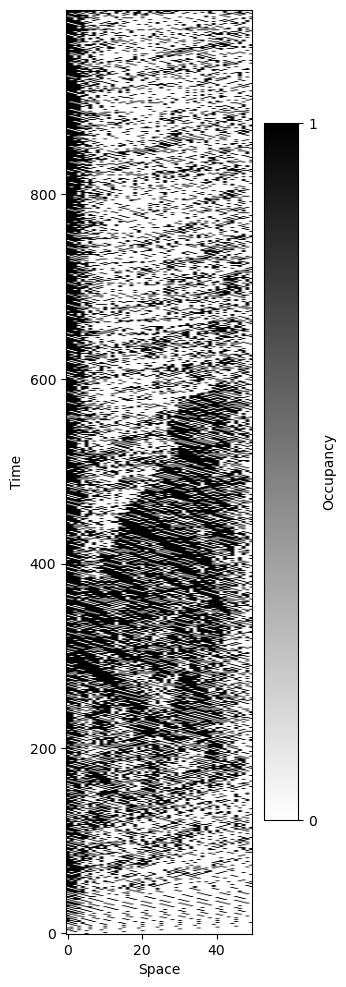

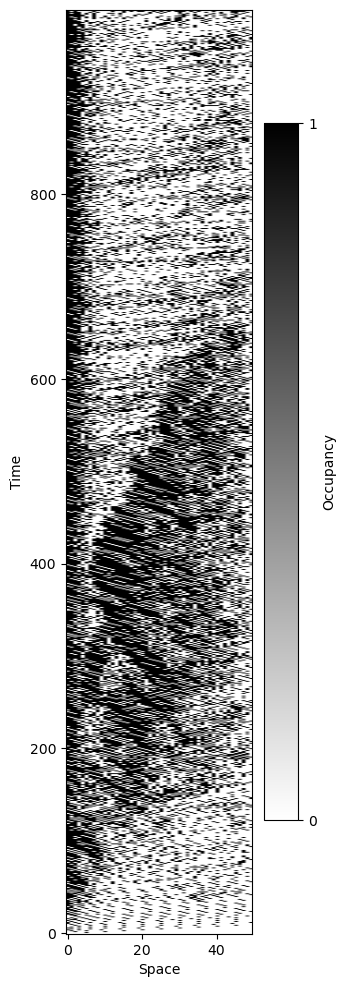

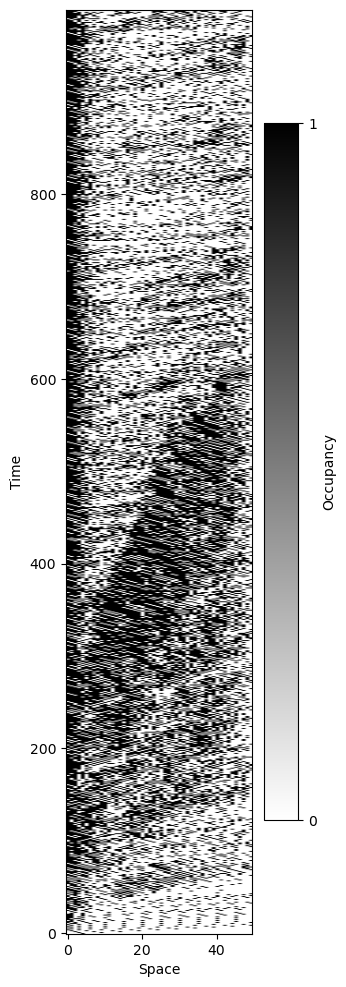

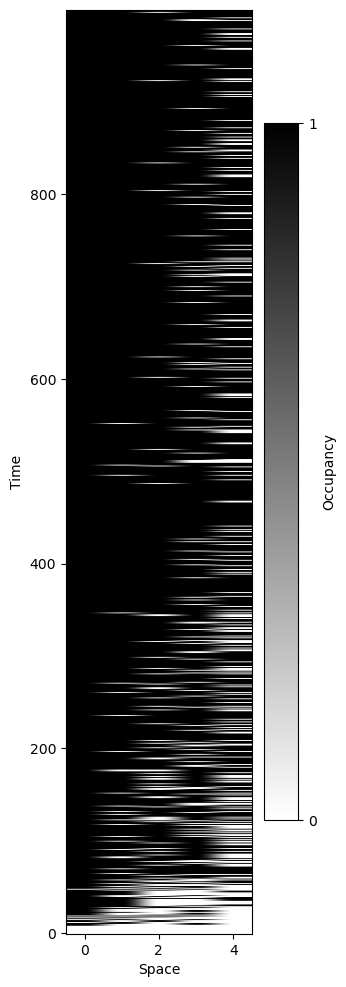

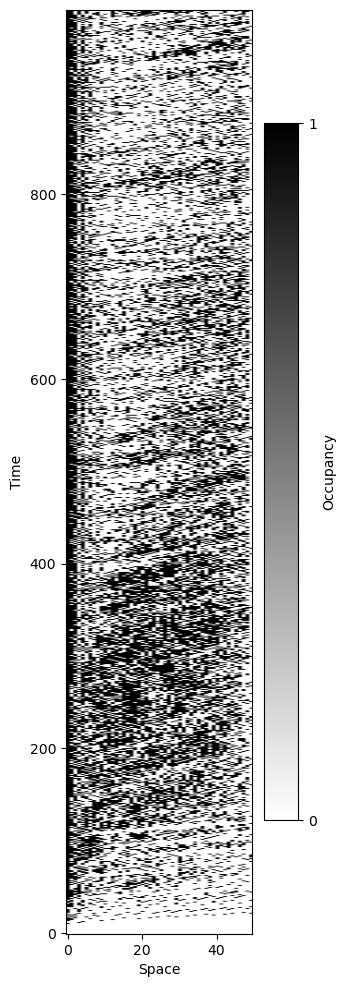

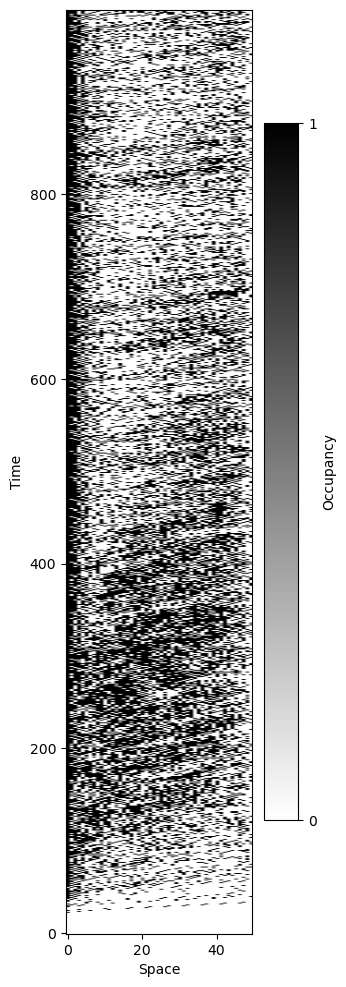

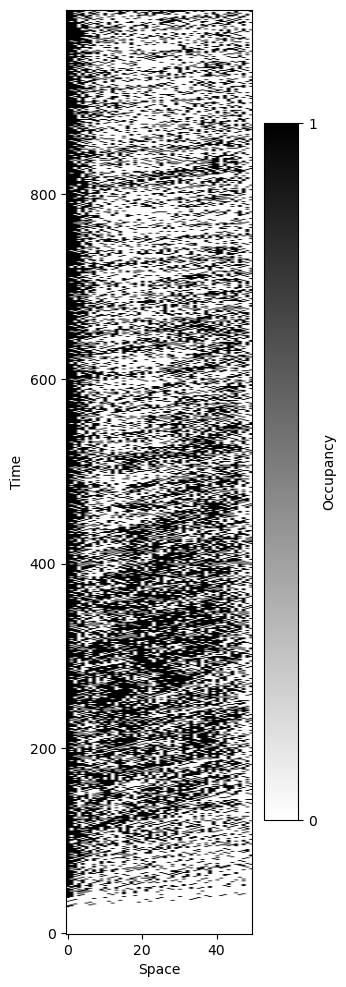

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import csv

class Vehicle:
    def __init__(self, vehicle_id, position, speed, max_speed, braking_prob):
        self.vehicle_id = vehicle_id
        self.position = position
        self.speed = speed
        self.max_speed = max_speed
        self.braking_prob = braking_prob

    def accelerate(self):
        if self.speed < self.max_speed:
            self.speed += 1

    def decelerate(self, gap_distance):
        if self.speed > gap_distance:
            self.speed = gap_distance

    def randomize(self, braking_prob):
        if np.random.rand() < braking_prob:
            if self.speed > 0:
                self.speed -= 1

class Road_Configuration:
    def __init__(self, road_length, road_width, production_prob, max_speed):
        self.road_length = road_length
        self.road_width = road_width
        self.production_prob = production_prob
        self.max_speed = max_speed
        self.road_occupancy = np.zeros((self.road_length, self.road_width), dtype=int)
        self.vehicles = []
        self.vehicle_counter = 0  # To assign unique IDs to vehicles

    def update_occupancy(self):
        self.road_occupancy.fill(0)  # Reset occupancy grid
        for vehicle in self.vehicles:
            if vehicle.position < self.road_length:  # Only update occupancy if within road length
                self.road_occupancy[vehicle.position, 0] = 1  # Assuming single-lane for simplicity

    def produce_vehicles(self):
        if np.random.rand() < self.production_prob:
            if np.sum(self.road_occupancy[0, :]) == 0:  # Check the availability of the first cell
                new_vehicle = Vehicle(self.vehicle_counter, 0, np.random.randint(1, self.max_speed + 1), self.max_speed, 0.01)
                self.vehicle_counter += 1
                self.vehicles.append(new_vehicle)
                self.road_occupancy[new_vehicle.position, 0] = 1  # Mark the position as occupied

    def gap_distance(self, vehicle):
        current_position = vehicle.position
        for distance in range(1, self.road_length):
            next_position = current_position + distance
            if next_position >= self.road_length:
                break
            if self.road_occupancy[next_position, 0] == 1:
                return distance - 1
        return self.road_length - 1

    def update(self):
        self.update_occupancy()
        for vehicle in self.vehicles:
            distance_to_next = self.gap_distance(vehicle)
            vehicle.accelerate()
            vehicle.decelerate(distance_to_next)
            vehicle.randomize(vehicle.braking_prob)
            vehicle.position += vehicle.speed

        self.update_occupancy()

    def vehicle_density(self):
        return len(self.vehicles) / self.road_length

class Traffic_System:
    def __init__(self, roads):
        self.roads = roads
        self.occupancy_history = []  # To store the road occupancy at each time step
        self.exiting_data = []  # To store the number of vehicles exiting each road at each timestep

    def transfer_vehicle(self, vehicle, to_road):
        vehicle.position = 0  # Reset position to the beginning of the new road
        to_road.vehicles.append(vehicle)
        to_road.update_occupancy()

    def update(self):
        timestep_exiting_data = []
        for road in self.roads:
            timestep_exiting_data.append({
                "Timestep": len(self.occupancy_history) + 1,
                "Road_number": self.roads.index(road) + 1,
                "Vehicle_density": road.vehicle_density(),
                "Vehicles_Exiting": 0
            })

        # First three roads produce vehicles
        for road in self.roads[:3]:
            road.produce_vehicles()

        # Update all roads
        for road in self.roads:
            road.update()

        # Transfer vehicles from first three roads to the fourth road (node)
        node_road = self.roads[3]
        for road in self.roads[:3]:
            vehicles_to_transfer = [vehicle for vehicle in road.vehicles if vehicle.position >= road.road_length]
            for vehicle in vehicles_to_transfer:
                self.transfer_vehicle(vehicle, node_road)
                timestep_exiting_data[self.roads.index(road)]["Vehicles_Exiting"] += 1
            road.vehicles = [vehicle for vehicle in road.vehicles if vehicle.position < road.road_length]

        # Transfer vehicles from the fourth road (node) to the available roads (5, 6, 7)
        for vehicle in node_road.vehicles[:]:
            if vehicle.position >= node_road.road_length:
                transferred = False
                for target_road in self.roads[4:]:
                    if np.sum(target_road.road_occupancy[0, :]) == 0:  # Check the availability of the first cell
                        self.transfer_vehicle(vehicle, target_road)
                        transferred = True
                        break
                if transferred:
                    node_road.vehicles = [v for v in node_road.vehicles if v.vehicle_id != vehicle.vehicle_id]
                    timestep_exiting_data[3]["Vehicles_Exiting"] += 1

        # Store the occupancy history for all roads
        self.occupancy_history.append([road.road_occupancy.copy() for road in self.roads])
        self.exiting_data.extend(timestep_exiting_data)

def save_exiting_data_to_csv(traffic_system, filename):
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.DictWriter(csvfile, fieldnames=["Timestep", "Road_number", "Vehicle_density", "Vehicles_Exiting"])
        csvwriter.writeheader()
        csvwriter.writerows(traffic_system.exiting_data)

def save_occupancy_history_to_csv(traffic_system, filename):
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)

    # Define column names
        column_names = ["Time Step", "Road ID", "Position", "Occupied"]

    # Write column names as the header row
        csvwriter.writerow(column_names)

        for t, state in enumerate(traffic_system.occupancy_history):
          for road_id, road_occupancy in enumerate(state):
            for position, occupied in enumerate(road_occupancy):
              # Write data with corresponding column names
              csvwriter.writerow([t + 1, road_id + 1, position, occupied[0]])

def plot_spatio_temporal_figures(traffic_system):
    num_roads = len(traffic_system.roads)
    for road_id in range(num_roads):
        fig, ax = plt.subplots(figsize=(3, 12))
        occupancy_history = [state[road_id] for state in traffic_system.occupancy_history]
        occupancy_array = np.array(occupancy_history).reshape(len(occupancy_history), -1)
        im = ax.imshow(occupancy_array, aspect='auto', cmap='binary', origin='lower')
        ax.set_xlabel('Space')
        ax.set_ylabel('Time')
        #ax.set_title(f'Spatio-temporal Plot of Vehicle Positions (Road {road_id + 1})')

        # Create custom legend
        cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
        cbar.set_label('Occupancy')
        plt.savefig(f'ROAD19_Spatio-Temporal_Road_{road_id + 1}.png')
        plt.show()

# Example usage:
road1 = Road_Configuration(road_length=50, road_width=1, production_prob=0.9, max_speed=5)
road2 = Road_Configuration(road_length=50, road_width=1, production_prob=0.9, max_speed=5)
road3 = Road_Configuration(road_length=50, road_width=1, production_prob=0.9, max_speed=5)
node_road = Road_Configuration(road_length=5, road_width=1, production_prob=0.0, max_speed=5)
road5 = Road_Configuration(road_length=50, road_width=1, production_prob=0.0, max_speed=5)
road6 = Road_Configuration(road_length=50, road_width=1, production_prob=0.0, max_speed=5)
road7 = Road_Configuration(road_length=50, road_width=1, production_prob=0.0, max_speed=5)

traffic_system = Traffic_System(roads=[road1, road2, road3, node_road, road5, road6, road7])

for _ in range(1000):  # Simulate 2000 time steps
    traffic_system.update()

# Specify the file path for saving the CSV
occupancy_file_path = 'occupancy_history_19.csv'
exiting_data_file_path = 'exiting_data_19.csv'

# Save occupancy history to CSV
save_occupancy_history_to_csv(traffic_system, occupancy_file_path)
print(f"Occupancy history saved to {occupancy_file_path}")

# Save exiting data to CSV
save_exiting_data_to_csv(traffic_system, exiting_data_file_path)
print(f"Exiting data saved to {exiting_data_file_path}")

# Plot the spatio-temporal graphs as separate figures
plot_spatio_temporal_figures(traffic_system)